In [1]:
from __future__ import print_function
import argparse, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

In [2]:
import baseline

In [3]:
import os

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None, target_transform=None):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.fname_list = None
        self.base_dir = base_dir
        self.target_transform = target_transform
        self.create_fname_list()
        self.img_labels = self.fname_list

    def create_fname_list(self):
        self.fname_list = os.listdir(os.path.join(self.base_dir, '2012'))
        self.fname_list = list(filter(lambda x: x.find("jpg") != -1, self.fname_list))
        self.fname_list = list(map(lambda x: x[5: ], self.fname_list))

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # TODO: refactor
        img_path = os.path.join(self.base_dir, '2012', '2012_' + self.fname_list[idx])
        img_path2 = os.path.join(self.base_dir, '2016', '2016_' + self.fname_list[idx])
        image = plt.imread(img_path)
        image2 = plt.imread(img_path2)
        p2 = np.array(np.zeros((3, 256, 256)))
        p2[0, ...] = image[..., 0]
        p2[1, ...] = image[..., 1]
        p2[2, ...] = image[..., 2]
        p3 = np.array(np.zeros((3, 256, 256)))
        p3[0, ...] = image2[..., 0]
        p3[1, ...] = image2[..., 1]
        p3[2, ...] = image2[..., 2]
        label_path = os.path.join(self.base_dir, 'label', 'label_' + self.fname_list[idx])
        image_label = plt.imread(label_path)
        label = np.divide(image_label[..., 0], 255).astype(int)
        # lab = np.array(np.zeros((1, 256, 256)))
        # lab[0, :, :] = label
        tor = torch.from_numpy(p2)
        tor2 = torch.from_numpy(p3)
        feature = self.normalize_image(tor)
        feature2 = self.normalize_image(tor2)
        print(img_path)

        return feature, feature2, torch.from_numpy(label).float()

In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
device = torch.device("cuda")
train_dataset = CustomImageDataset('images/largechange')
train_kwargs = {'batch_size': 3}
test_kwargs = {'batch_size': 1000}
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)

model = baseline.SiameseNetwork().to(device)
model.load_state_dict(torch.load('siamese_network0.pt'))

<All keys matched successfully>

In [6]:
loader = train_loader.__iter__()

In [14]:
im1, im2, tar = next(loader)

images/largechange/2012/2012_6000_6743.jpg
images/largechange/2012/2012_11000_17743.jpg
images/largechange/2012/2012_1500_17243.jpg


In [15]:
tar[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
im1[0][0].shape

torch.Size([256, 256])

In [25]:
im1, im2, tar = next(loader)

images/largechange/2012/2012_14500_18243.jpg
images/largechange/2012/2012_8000_20243.jpg
images/largechange/2012/2012_4000_18743.jpg


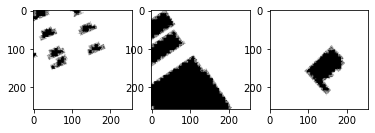

In [26]:
num = 2
# plt.subplot(1, 3, 1)
# narr = np.zeros((256, 256, 3))
# narr[...,0] = im1[num, 0, ...]
# narr[...,1] = im1[num, 1, ...]
# narr[...,2] = im1[num, 2, ...]
# plt.imshow(narr)
# plt.subplot(1, 3, 2)
# narr1 = np.zeros((256, 256, 3))
# narr1[...,0] = im2[num, 0, ...]
# narr1[...,1] = im2[num, 1, ...]
# narr1[...,2] = im2[num, 2, ...]
# plt.imshow(narr1)
plt.subplot(1, 3, 1)
plt.imshow(tar[0], cmap = 'Greys')
plt.subplot(1, 3, 2)
plt.imshow(tar[1], cmap = 'Greys')
plt.subplot(1, 3, 3)
plt.imshow(tar[num], cmap = 'Greys')


In [27]:
# plt.imshow(tar[num])
result = model(im1.to('cuda'), im2.to('cuda'))

torch.Size([3, 1, 256, 256])


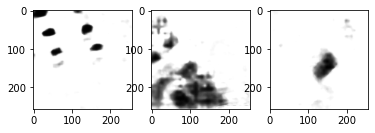

In [28]:
plt.subplot(1, 3, 1)
plt.imshow(result[0][0].cpu().detach().numpy(), cmap = 'Greys')
plt.subplot(1, 3, 2)
plt.imshow(result[1][0].cpu().detach().numpy(), cmap = 'Greys')
plt.subplot(1, 3, 3)
plt.imshow(result[num][0].cpu().detach().numpy(), cmap = 'Greys')

In [58]:
from torchinfo import summary

ModuleNotFoundError: No module named 'torchinfo'

In [ ]:
summary(model, [(1, 3, 256, 256), (1, 3, 256, 256)])
